In [1]:
import numpy as np
from matplotlib import pyplot as plt

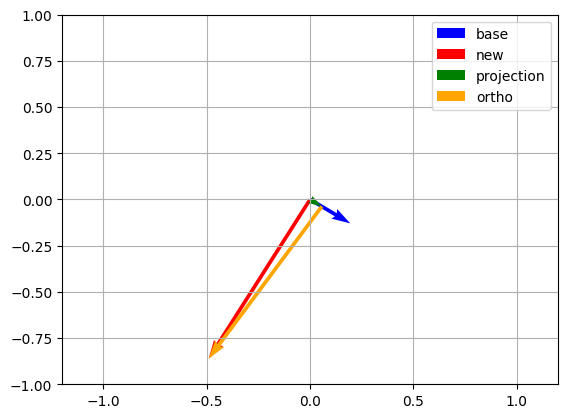

In [96]:
base = np.random.rand(2)*2 - 1
new = np.random.rand(2)*2 - 1

projection = base@new / (base@base) * base
ortho = new - projection

ortho_matrix = np.eye(2)- base[:,np.newaxis]@base[np.newaxis,:]/(base@base)
ortho = ortho_matrix@new

# plot the two vectors
plt.quiver(0,0, base[0], base[1], angles='xy', scale_units='xy', scale=1, color='b', label='base')
plt.quiver(0,0, new[0], new[1], angles='xy', scale_units='xy', scale=1, color='r', label='new')
plt.quiver(0,0, projection[0], projection[1], angles='xy', scale_units='xy', scale=1, color='g', label='projection')
plt.quiver(projection[0], projection[1], ortho[0], ortho[1], angles='xy', scale_units='xy', scale=1, color='orange', label='ortho')


plt.xlim(-1.2,1.2)
plt.ylim(-1,1)
#plt.axis('equal')

plt.grid()
plt.legend()
plt.show()


In [ ]:
def initialize_all(y0, t0, t, n):
    """ An initialization routine for the different ODE solving
    methods in the lab. This initializes Y, T, and h. """
    if isinstance(y0, np.ndarray):
        Y = np.empty((n, y0.size)).squeeze()
    else:
        Y = np.empty(n)
    
    Y[0] = y0
    T = np.linspace(t0, t, n)
    h = float(t - t0) / (n - 1)
    return Y, T, h

def RK4(f, y0, t0, t, n):
    """ Use the RK4 method to compute an approximate solution
    to the ODE y' = f(t, y) at n equispaced parameter values from t0 to t
    with initial conditions y(t0) = y0.
    
    y0 is assumed to be either a constant or a one-dimensional numpy array.
    t and t0 are assumed to be constants.
    f is assumed to accept three arguments.
    The first is a constant giving the value of t.
    The second is a one-dimensional numpy array of the same size as y.
    The third is an index to the other arrays.
    
    This function returns an array Y of shape (n,) if
    y is a constant or an array of size 1.
    It returns an array of shape (n, y.size) otherwise.
    In either case, Y[i] is the approximate value of y at
    the i'th value of np.linspace(t0, t, n).
    """
    Y,T,h = initialize_all(y0,t0,t,n)
    for i in range(n-1):
        K1 = f(T[i],Y[i],i)
        K2 = f(T[i]+h/2.,Y[i]+h/2.*K1,i)
        K3 = f(T[i]+h/2.,Y[i]+h/2.*K2,i)
        K4 = f(T[i+1],Y[i]+h*K3,i)
        Y[i+1] = Y[i] + h/6.*(K1+2*K2 +2*K3+K4)
    return Y

def solve_tree_harvest(x0, k, r, T, N=1000, delta=0.001):
    """
    Solves for the optimal control for the tree harvesting problem 
    with the given parameters.
    
    Parameters:
        x0 - initial amount of timber being produced
        k - investment growth rate
        r - interest rate
        T - final time
        N - number of time steps
        delta - error tolerance for convergence
    Returns:
        t ((N+1), ndarray) - timesteps
        x ((N+1), ndarray) - timber production values
        u ((N+1), ndarray) - the optimal control
    """
    t = np.linspace(0,T,N+1)
    h = T/N
    h2 = h/2
    
    x = np.zeros(N+1)
    alpha = np.zeros(N+1)
    u = np.zeros(N+1)
    
    while True:
        oldx = x.copy()
        oldalpha = alpha.copy()
        oldu = u.copy()
        
        # Solve for x (iterate through each t (x[t])) (1.2)
        def ode(t, x, i):
            return k*x*u[i]
        
        x = RK4(ode, x0, 0, T, N+1)
        
        # Solve for alpha (iterate backwords through each t (alpha[t])) (1.5)
        def ode_alpha(t, alpha, i):
            return u[-1-i] * (np.exp(-r*(t)) - k * alpha) - np.exp(-r * t)
        
        alpha = RK4(ode_alpha, 0, T, 0, N+1)[::-1]

        # Solve for u (iterate through each t u[t]) (1.6 and right below)
        phi = x * (k * alpha - np.exp(-r * t))
        u = 1. * (phi > 0)
        
        # Check for convergence
        if (np.sum(np.abs(oldu - u)) < delta*np.sum(np.abs(u))
            and np.sum(np.abs(oldx - x)) < delta*np.sum(np.abs(x))
            and np.sum(np.abs(oldalpha - alpha)) < delta*np.sum(np.abs(alpha))):
            break
    return t, x, u